# ABS Monthly Labour Force 6202

## Python set-up

In [1]:
# system imports
import sys
import pathlib
import calendar
import datetime

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# local imports
from finalise_plot import finalise_plot
from abs_common import (
    get_fs_constants,
    get_ABS_meta_and_data,
    get_plot_constants,
    get_identifier,
    find_id,
    plot_Mgrowth,
    recalibrate_series,
    clear_chart_dir, 
    plot_covid_recovery
)

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# plotting stuff
plt.style.use('fivethirtyeight')

In [2]:
catalogue_id = '6202'
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)
clear_chart_dir(CHART_DIR)

# some useful columns in the meta data
table_col = 'Table'
did_col = 'Data Item Description'
type_col = 'Series Type'
unit_col = 'Unit'

## Get data from ABS

In [3]:
# do the data capture and extraction
abs_dict = get_ABS_meta_and_data(catalogue_id)
if abs_dict is None:
    sys.exit(-1)
    
meta = abs_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)

Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


## Plot

### Set-up some constants we will use across all plots

In [4]:
meta = abs_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)

# reference point for COVID comparisons
REFERENCE = pd.Timestamp('2020-02-01')
REF_STRING = f'{calendar.month_abbr[REFERENCE.month]} {REFERENCE.year}'
index_base = 100

### Headline charts

Note: with COVID, the ABS has stopped publishing the Trend series.  

In [5]:
headlines = {
    # data item                                       # table number
    'Employed total ;  Persons ;':                    '1',
    '> Employed part-time ;  Persons ;':              '1',
    '> Employed full-time ;  Persons ;':              '1',
    'Unemployed total ;  Persons ;':                  '1',
    'Unemployment rate ;  Persons ;':                 '1', 
    'Participation rate ;  Persons ;':                '1',
    'Labour force total ;  Persons ;':                '1',
    'Monthly hours worked in all jobs ;  Persons ;':  '19',
}
series_type = "Seasonally Adjusted"

for headline, table in headlines.items():

    df = abs_dict[table]
    seasadj, units = get_identifier(meta, headline, 
                                    series_type, table)
    series = df[seasadj]
    series, units = recalibrate_series(series, units)
    
    for start, tag in zip(plot_times, plot_tags):
        subset = series[series.index >= pd.Period(start, freq='M')] if start else series
        ax = subset.plot(c='#dd0000', lw=2)
        ax.legend([series_type], loc='best')
        title = f'Australia: {headline}'.replace(' ;', '').replace('  ', ' ')
        finalise_plot(
            ax, title, units, tag, CHART_DIR,
            rfooter=f'{source} {table}',
            #show=True,
        )

### Covid recovery checks

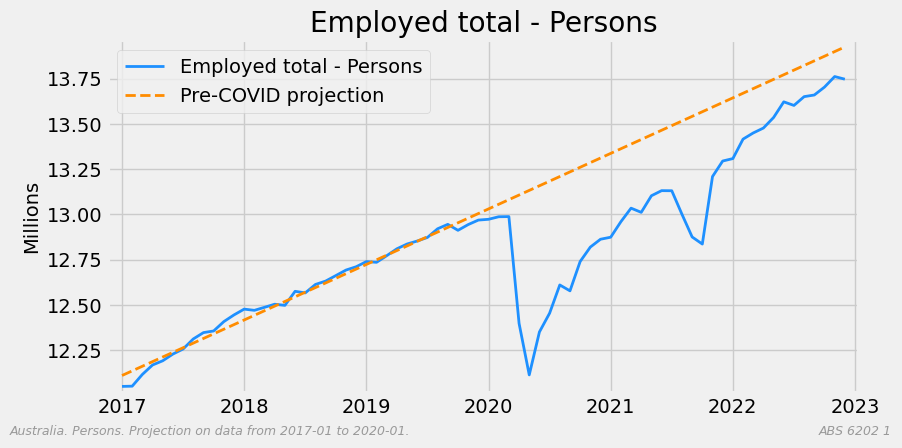

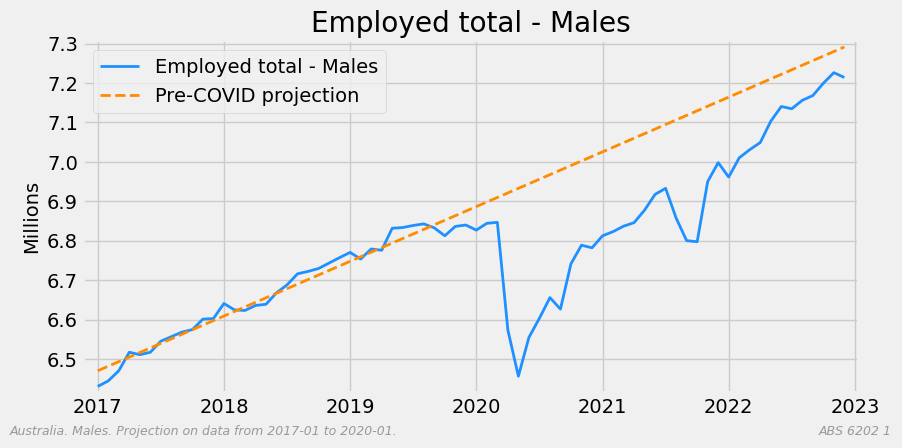

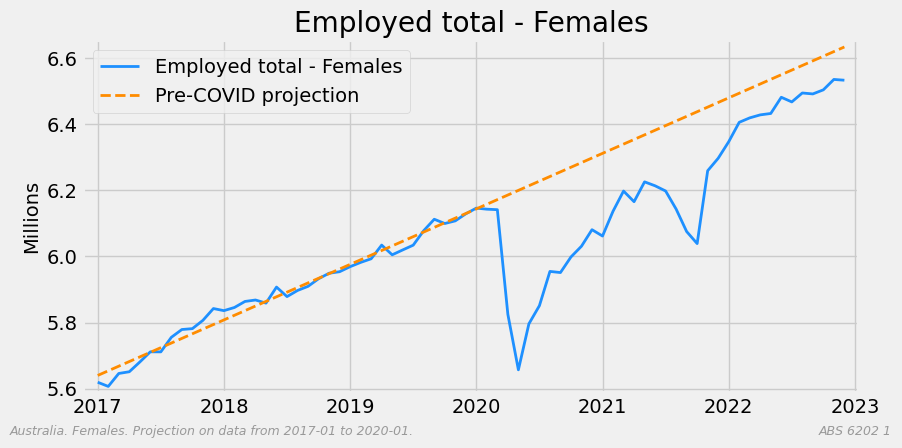

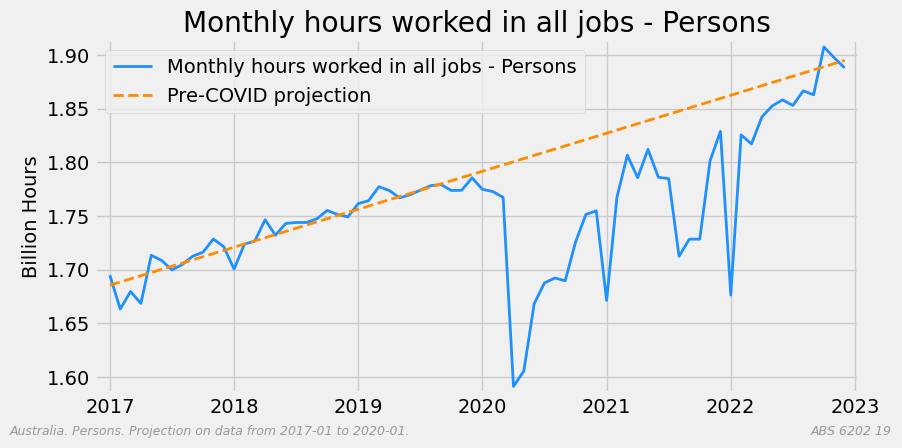

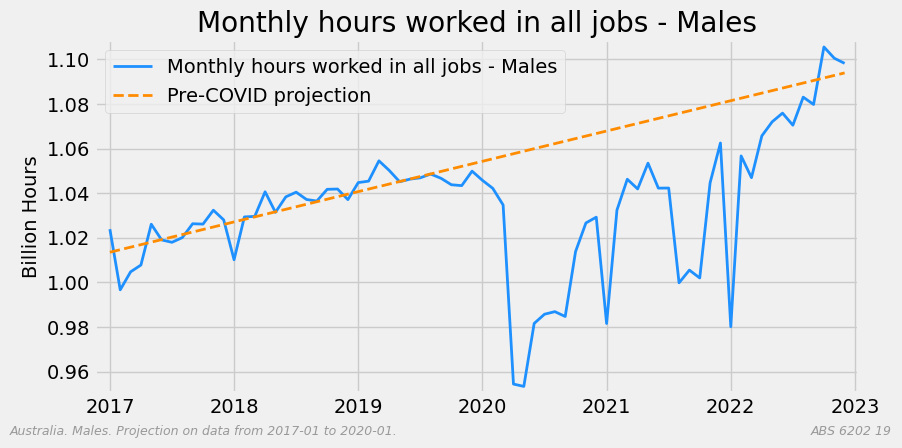

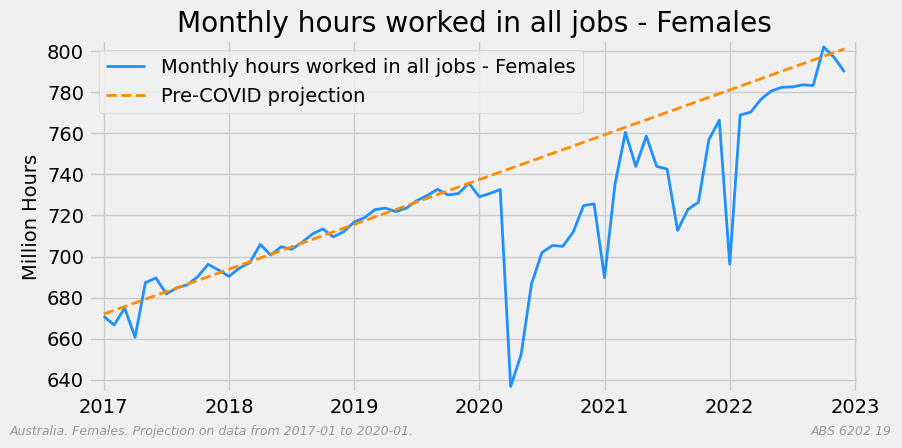

In [6]:
headlines = {
    # data item                                       # table number
    'Employed total':                    '1',
    'Monthly hours worked in all jobs':  '19',
}
series_type = "Seasonally Adjusted"

for headline, table in headlines.items():
    for person in ('Persons', 'Males', 'Females'):
        selector = {
            table: table_col,
            f'{headline} ;': did_col,
            person: did_col,
            series_type: type_col,
        }
        id, units = find_id(meta, selector, verbose=False)
        series, units = recalibrate_series(abs_dict[table][id], units)
        title = f'{headline} - {person}'
        series.name = title

        plot_covid_recovery(
            series,
            title, 
            f'{units}', 
            '-recent-COVID', 
            CHART_DIR,
            rfooter=f'{source} {table}',
            lfooter=f'Australia. {person}. ',
            show=True,
        )

### State comparisons 

In [7]:
states = {
    # state                     # table
    "NSW":                      '4',
    "Vic":                      '5',
    "Qld":                      "6",
    "SA":                       "7",
    "WA":                       "8",
    "Tas":                      "9",
}

plots = [
    'Unemployment rate ;  Persons ;', 
    'Participation rate ;  Persons ;',
]

colours = ['blue', 'darkorchid', 'brown', 'olivedrab', 'red', 
           'darkorange', 'darkgoldenrod', 'teal',]

series_type = "Seasonally Adjusted"

for plot in plots:
    
    collection = []
    tables = []
    df = pd.DataFrame()
    for state, table in states.items():
        id, units = get_identifier(meta, plot, series_type, table)
        collection.append(id)
        tables.append(table)
        df = abs_dict[table] if df.empty else df.join(abs_dict[table])
    
    for start, tag in zip(plot_times, plot_tags):
        frame = df[df.index >= pd.Period(start, freq='M')] if start else df
        ax = frame[collection].plot(lw=2, color=colours)
        ax.legend(states.keys(), loc='lower left', ncol=3)
        title = f'Australian states: {plot}'
        finalise_plot(
            ax, title, units, tag, CHART_DIR,
            rfooter=f'{source}s {",".join(tables)}',
            lfooter=f'From {series_type.lower()} series',
            #show=True,
        )

### National/State Growth

In [8]:
series_type = "Seasonally Adjusted"
tables = ['12', '12a']
plot_stems = [
    'Employed total ;  Persons ;',
    '> Employed full-time ;  Persons ;',
    '> Employed part-time ;  Persons ;',
    'Unemployed total ;  Persons ;',
    'Labour force total ;  Persons ;',
]

for stem in plot_stems:
    for table in tables:
        
        descriptions = meta[
            (meta['Table'] == table) &
            (meta['Series Type'] == series_type) &
            (meta['Data Item Description'].str.contains(stem))
        ]['Data Item Description']
        
        for desc in descriptions:
            
            # get the relevant ABS series identifier
            series, units = get_identifier(meta, desc, series_type, table)
            
            # plot
            desc_title = desc.replace('> ', '').replace(' ;', '').replace('  ', ' ')
            title = f'Growth: {desc_title}'
            df = abs_dict[table]
            for plot_from, plot_tag in zip(plot_times, plot_tags):
                p_plot_from = pd.Period(plot_from, freq='M') if plot_from else None
                plot_Mgrowth(
                    df[series], 
                    title, p_plot_from, 
                    plot_tag, CHART_DIR,
                    lfooter=f'Calculated from {series_type.lower()} series', 
                    rfooter=f'{source} {table}',
                    #show=True,
                )

### Gendered comparisons

In [9]:
genders = ['Males', 'Females']
colours = ['cornflowerblue', 'hotpink']

TOKEN = 'by gender' # note: also appears in plot title
plots = {
    # data description                       # table
    f'Employed total ;  > {TOKEN} ;':       '1',
    f'> Employed part-time ;  > {TOKEN} ;': '1',
    f'> Employed full-time ;  > {TOKEN} ;': '1',
    f'Unemployed total ;  > {TOKEN} ;':     '1',
    f'Labour force total ;  > {TOKEN} ;':     '1',
    f"Unemployment rate ;  > {TOKEN} ;":    '1',
    f"Participation rate ;  > {TOKEN} ;":   '1',
    f'Monthly hours worked in all jobs ;  > {TOKEN} ;':  '19',
}

series_type = "Seasonally Adjusted"

for plot, table in plots.items():
    
    # assemble data
    collection = []
    for gender in genders:
        this_gender = plot.replace(TOKEN, gender)
        ident, units = get_identifier(meta, this_gender, 
                                   series_type, table)
        collection.append(ident)

    # plot
    df = abs_dict[table][collection]
    
    # Hours is a special case
    if units in ['000 Hours', 'Thousand Hours']:
        units = 'Billion Hours'
        df = df / 1_000_000

    for start, tag in zip(plot_times, plot_tags):
        
        frame = df[df.index >= pd.Period(start, freq='M')] if start else df
        ax = frame.plot(lw=2, color=colours)
        ax.legend(genders, loc='best')
        title = f"Australia: {plot}".replace(' ;', '').replace('  ', ' ')
        finalise_plot(
            ax, title, units, tag, CHART_DIR,
            rfooter=f'{source} {table}',
            lfooter=f'From {series_type.lower()} series',
            #show=True,
        )
        


## Finished

In [10]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Wed Feb 15 2023 19:30:19

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.10.0

sys       : 3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]
pandas    : 1.5.3
matplotlib: 3.7.0
numpy     : 1.24.2

Watermark: 2.3.1



In [11]:
print('Finished')

Finished
